In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import math
%matplotlib inline

In [204]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value({self.data})'

    def __radd__(self, other): # other + self
        return self + other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self - other

    def __rmul__(self, other):
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'Supports int and floats only.'
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def tanh(self):
        x = self.data
        tanh = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(tanh, (self,), 'tanh')

        def _backward():
            self.grad += (1.0 - (tanh**2)) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    

In [24]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [25]:
val1 = Value(5,label='a')
val2 = Value(9, label='b')
val3 = Value(13, label='c')
val4 = val1*val2
val4.label = 'd'
out = val4+val3
out.label = 'o'

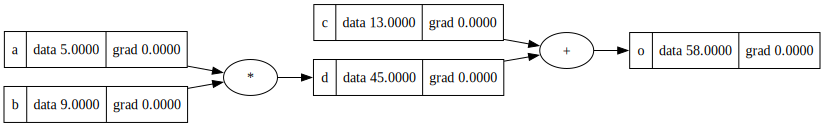

In [26]:
draw_dot(out)

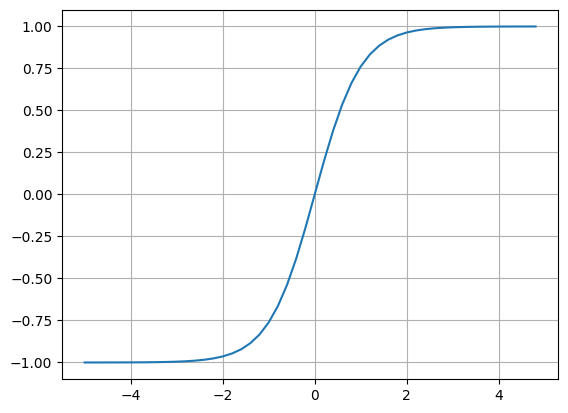

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [109]:
############## Setting a Neuron ###############
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# Neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

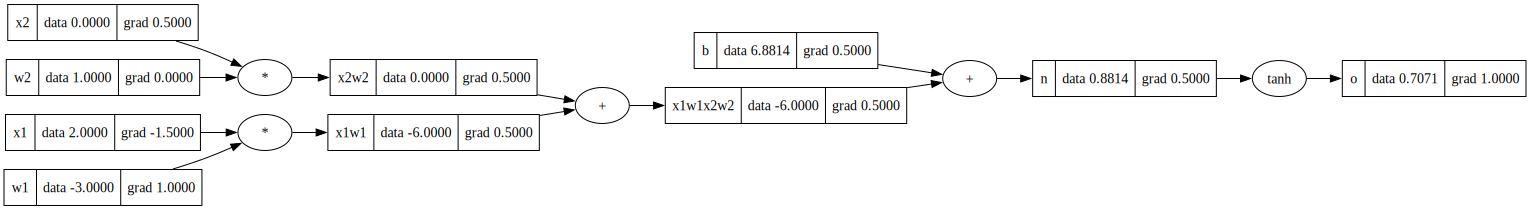

In [108]:
draw_dot(o)

In [107]:
# Manual Back Propagation
o.grad = 1 # Since dy/dy = 1
n.grad = 0.5 # do/dn = d(tanh(n))/dn = 1 - (tanh(n))**2

# do/d(x1w1x2w2) = do/dn * dn/d(x1w1x2w2) => Since we know do/dn = 0.5,
# and also we know dn/d(x1w1x2w2) = 1 as n = x1w1x2w2 + b
x1w1x2w2.grad = 0.5
b.grad = 0.5 # similar to x1w1x2w2

x1w1.grad = 0.5 # since do/dx1w1 = do/d(x1w1x2w2) * d(x1w1x2w2)/d(x1w1), and d(x1w1x2w2)/d(x1w1) = 1 because x1w1x2w2 = x1w1 + x2w2
x2w2.grad = 0.5 # similar to x1w1

x2.grad = x2w2.grad * w2.data # using chain rule and since x2w2 = x2*w2
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data


In [81]:
# Back Propagation using the defined function in value class
o.grad = 1 # Base case
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

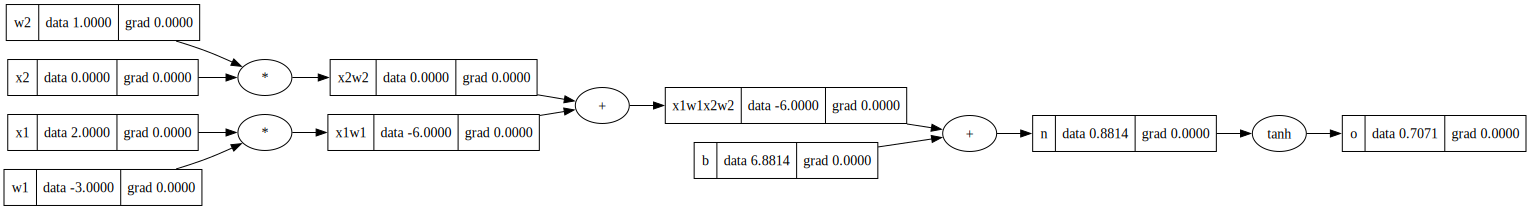

In [80]:
draw_dot(o)

In [83]:
# Automating back propagation using topological sorting
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(1.0),
 Value(0.0),
 Value(0.0),
 Value(-3.0),
 Value(2.0),
 Value(-6.0),
 Value(-6.0),
 Value(6.881373587019543),
 Value(0.8813735870195432),
 Value(0.7071067811865476)]

In [110]:
o.backward()

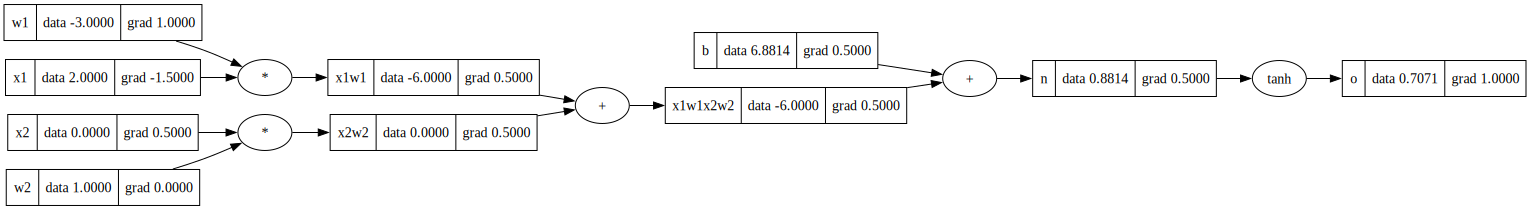

In [111]:
draw_dot(o)

In [123]:
a = Value(2.0, label='a')
b = a * a; b.label = 'b'
b.backward()


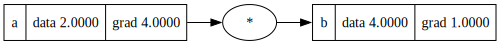

In [124]:
draw_dot(b)

In [149]:
a = Value(2.0, label='a')
b = Value(8.0, label='b')

In [205]:
# Use Value object to create a Multi Layer Perceptron

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        # nin -> inputs to the layer
        # nout -> neurons in this layer
        # create nout neurons that take nin inputs
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        # nin -> number of inputs to the Perceptron
        # nouts -> list of number of neurons in each layer 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # the output of Layer 1 will be input to Layer 2
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [206]:
perceptron = MLP(4, [4, 4, 1])

In [207]:
len(perceptron.parameters())

45

In [208]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [246]:
for step in range(2000):
    ypreds = [perceptron(x) for x in xs]
    loss = sum([(ygt - yp)**2 for ygt, yp in zip(ys, ypreds)])
    for p in perceptron.parameters():
        p.grad = 0
    loss.backward()
    for p in perceptron.parameters():
        p.data += -0.05 * p.grad
    if (step) == 0 or (step+1)%25 == 0:
        print(f'Step: {step + 1}, loss: {loss.data}')
    

Step: 1, loss: 4.6330288576735884e-05
Step: 25, loss: 4.6208739404906825e-05
Step: 50, loss: 4.608279850543327e-05
Step: 75, loss: 4.595753867558673e-05
Step: 100, loss: 4.583295441780454e-05
Step: 125, loss: 4.5709040293460455e-05
Step: 150, loss: 4.558579092207574e-05
Step: 175, loss: 4.546320098054984e-05
Step: 200, loss: 4.534126520239119e-05
Step: 225, loss: 4.521997837696983e-05
Step: 250, loss: 4.5099335348780005e-05
Step: 275, loss: 4.497933101671591e-05
Step: 300, loss: 4.485996033334833e-05
Step: 325, loss: 4.474121830423459e-05
Step: 350, loss: 4.4623099987212625e-05
Step: 375, loss: 4.4505600491724984e-05
Step: 400, loss: 4.4388714978149726e-05
Step: 425, loss: 4.427243865713179e-05
Step: 450, loss: 4.415676678894344e-05
Step: 475, loss: 4.404169468283841e-05
Step: 500, loss: 4.3927217696413916e-05
Step: 525, loss: 4.3813331234999175e-05
Step: 550, loss: 4.3700030751048326e-05
Step: 575, loss: 4.358731174352399e-05
Step: 600, loss: 4.347516975731355e-05
Step: 625, loss: 4.3

In [247]:
ypreds

[Value(0.9975937390371745),
 Value(-0.9973756014024677),
 Value(-0.9962890859065107),
 Value(0.9966017153981594)]